In [164]:
%matplotlib inline

# general
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Geographical analysis
#import pandas_geojson as geo_pd
import geopandas as geo_pd
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
#import shapefile as shp
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import requests
import missingno as msno
#import descartes

# accessibility analysis
import time
#from pandana.loaders import osm
#from pandana.loaders import pandash5

# modelling
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import metrics
#import xgboost as xgb
#from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score

# Set plot preference
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

print('Libraries imported.')

Libraries imported.


In [165]:
listings = pd.read_csv('https://www.inf.ed.ac.uk/teaching/courses/fds/data/project-2022-2023/airbnb/listings.csv.gz')

In [166]:
calendar = pd.read_csv('https://www.inf.ed.ac.uk/teaching/courses/fds/data/project-2022-2023/airbnb/calendar.csv.gz')

In [167]:
neighbourhoods = geo_pd.read_file('https://www.inf.ed.ac.uk/teaching/courses/fds/data/project-2022-2023/airbnb/neighbourhoods.geojson')

In [168]:
reviews = pd.read_csv('https://www.inf.ed.ac.uk/teaching/courses/fds/data/project-2022-2023/airbnb/reviews.csv.gz')

<AxesSubplot:>

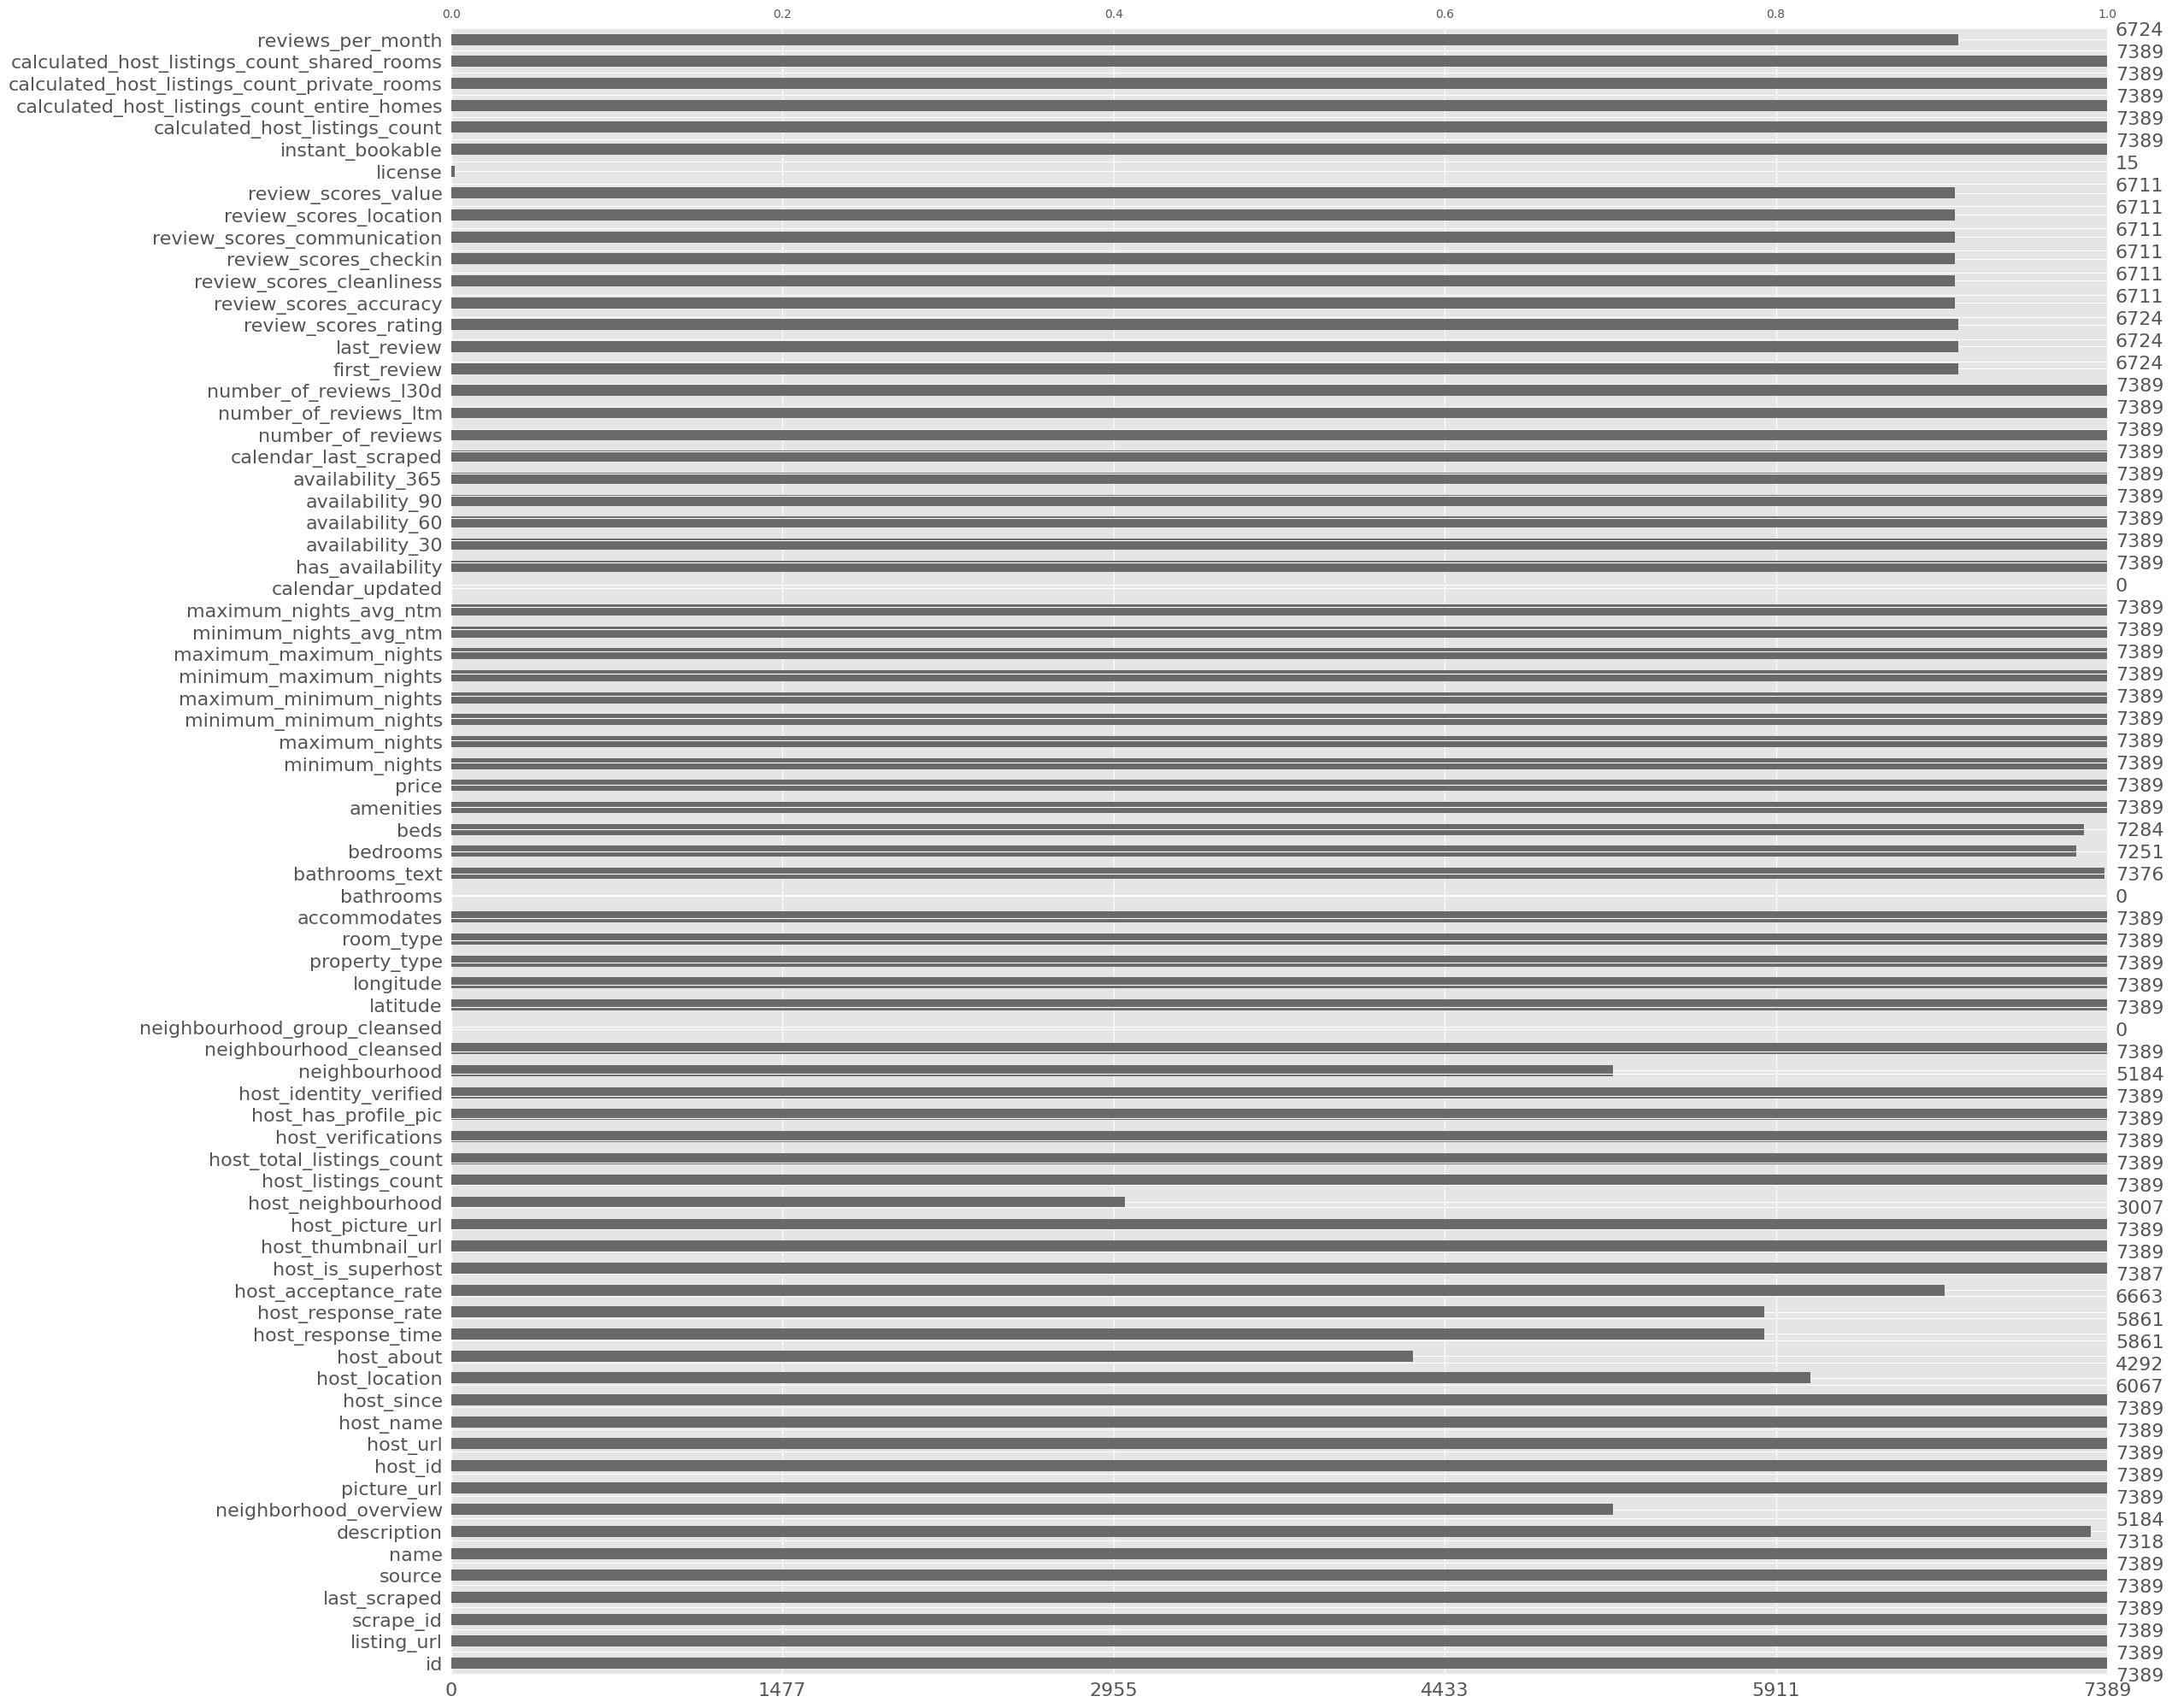

In [169]:
# CLEANING LISTINGS

msno.bar(listings)

## CLEANING DATA

In [170]:
clean_listings = listings.drop(['listing_url', 'scrape_id', 'last_scraped', 
                  'name', 'description', 'source', 'neighbourhood', 'neighbourhood_group_cleansed',
                  'neighborhood_overview',  'picture_url', 
                  'host_id', 'host_url', 'host_name', 'license',
                  'host_location', 'host_about', 'host_thumbnail_url', 
                  'host_picture_url', 'host_neighbourhood', 'host_verifications', 
                  'calendar_last_scraped', 'calendar_updated']
                    , axis=1)

In [171]:
pd.set_option('display.max_columns', len(clean_listings.columns)) # To view all columns
pd.set_option('display.max_rows', 100)
clean_listings.head(3)

,id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,15420,2009-12-06,within a few hours,100%,96%,t,3,6,t,t,"Old Town, Princes Street and Leith Street",55.95759,-3.18805,Entire rental unit,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Self check-in"", ""Hot water kettle"", ""Private...",$114.00,3,30,1,3,30,30,3.0,30.0,t,5,22,35,187,450,73,4,2011-01-18,2022-11-29,4.97,4.98,4.96,4.97,4.98,4.98,4.91,f,1,1,0,0,3.10
1,707097,2012-07-29,within a day,50%,84%,f,9,16,t,t,"Old Town, Princes Street and Leith Street",55.94980,-3.18354,Entire condo,Entire home/apt,9,NaN,2 baths,3.0,7.0,"[""TV with standard cable"", ""Stove"", ""Self chec...",$598.00,2,1000,28,300,1125,1125,104.3,1125.0,t,0,4,4,210,67,7,0,2013-01-03,2022-09-22,4.38,4.32,4.40,4.69,4.72,4.94,4.09,t,8,6,2,0,0.55
2,728199,2012-10-06,within an hour,100%,95%,t,1,2,t,t,Polwarth,55.93692,-3.22414,Private room in rental unit,Private room,3,NaN,1 private bath,1.0,1.0,"[""Self check-in"", ""Stove"", ""Bed linens"", ""Chil...",$60.00,1,14,1,4,14,14,1.3,14.0,t,6,24,49,195,354,52,2,2012-10-22,2022-12-04,4.82,4.86,4.81,4.95,4.97,4.73,4.79,f,1,0,1,0,2.86


In [172]:
clean_listings.isna().sum()

id                                                 0
host_since                                         0
host_response_time                              1528
host_response_rate                              1528
host_acceptance_rate                             726
host_is_superhost                                  2
host_listings_count                                0
host_total_listings_count                          0
host_has_profile_pic                               0
host_identity_verified                             0
neighbourhood_cleansed                             0
latitude                                           0
longitude                                          0
property_type                                      0
room_type                                          0
accommodates                                       0
bathrooms                                       7389
bathrooms_text                                    13
bedrooms                                      

## FILLING DATA

FILLING BATHROOM

In [173]:
# Extracting number of bathrooms from bathroom text
clean_listings['bathrooms'] = clean_listings['bathrooms_text'].str.extract(r'([\d.])').astype(float)
clean_listings.drop(['bathrooms_text'] , axis=1, inplace=True)

NEED TO REWRITE CODE!!
There are multiple columns for minimum and maximum night stays, but the two main ones will be used as there are few differences between e.g. minimum_nights and minimum_minimum_nights. The latter presumably refers to the fact that min/max night stays can vary over the year. The default (i.e. most frequently applied) min/max night stay values will be used instead.


In [174]:
clean_listings.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 
                    'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], axis=1, inplace=True)

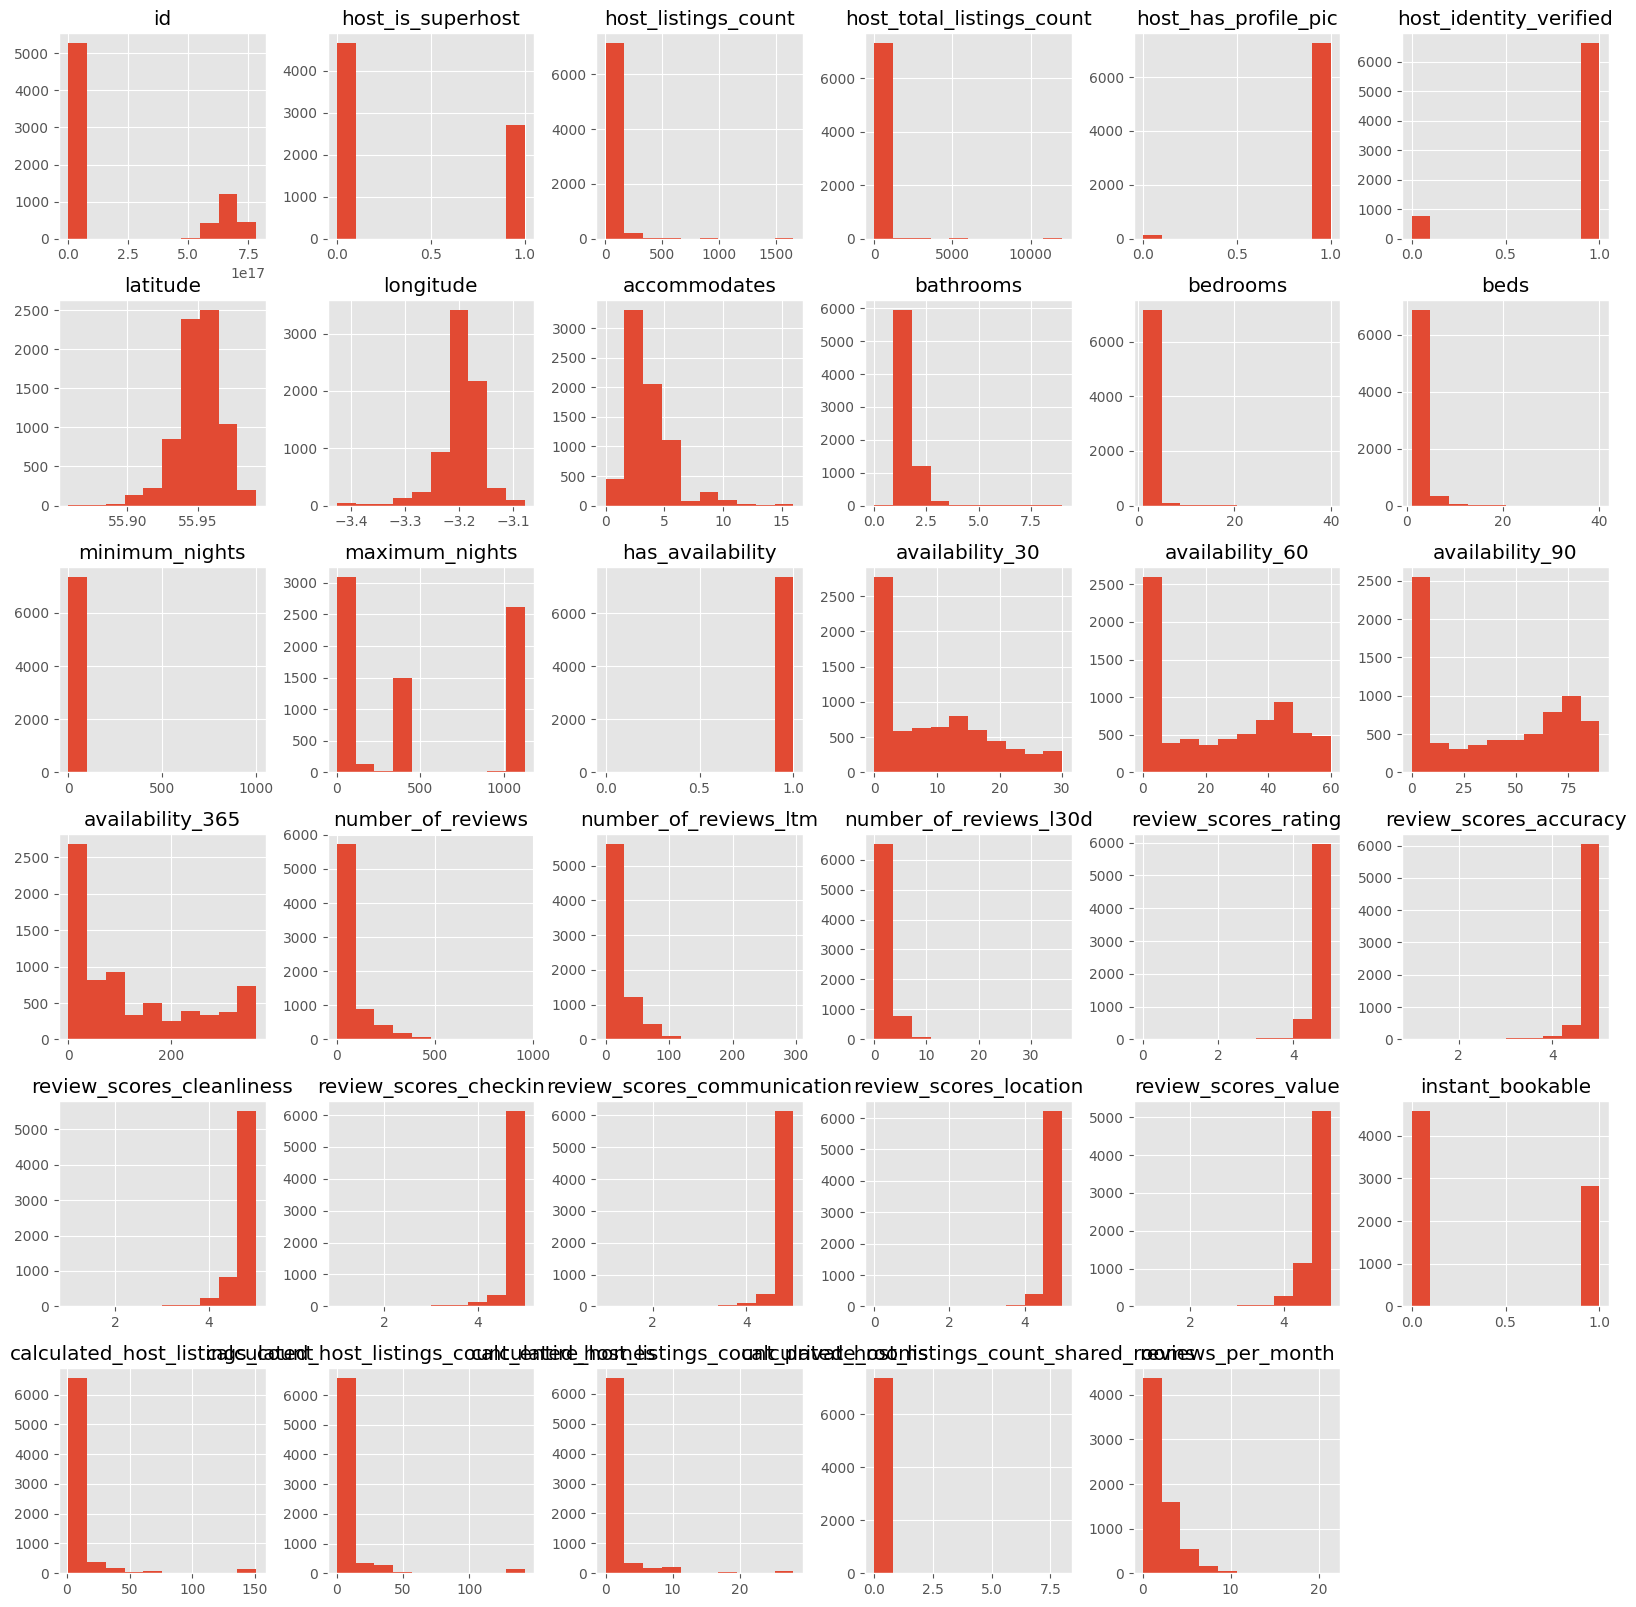

In [175]:
# Replacing columns with f/t with 0/1
clean_listings.replace({'f': 0, 't': 1}, inplace=True)

# Plotting the distribution of numerical and boolean categories
(clean_listings.hist(figsize=(20,20)));

In [176]:
clean_listings.drop(['has_availability', 'host_has_profile_pic'], axis=1, inplace=True)

In [177]:
# Converting to datetime
clean_listings.host_since = pd.to_datetime(clean_listings.host_since) 

# Calculating the number of days
clean_listings['host_days_active'] = (pd.datetime(2023, 3, 19) - clean_listings.host_since).astype('timedelta64[D]').astype('int')

# Printing mean and median
print("Mean days as host:", round(clean_listings['host_days_active'].mean(),0))
print("Median days as host:", clean_listings['host_days_active'].median())

# Replacing null values with the median
#clean_listings.host_days_active.fillna(clean_listings.host_days_active.median(), inplace=True)


Mean days as host: 2326.0
Median days as host: 2476.0


/tmp/ipykernel_2059/1861247951.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  clean_listings['host_days_active'] = (pd.datetime(2023, 3, 19) - clean_listings.host_since).astype('timedelta64[D]').astype('int')


In [178]:
print("Null values:", clean_listings.host_response_time.isna().sum())
print(f"Proportion: {round((clean_listings.host_response_time.isna().sum()/len(clean_listings))*100, 1)}%")

# Number of rows without a value for host_response_time which have also not yet had a review
# len(clean_listings[clean_listings.loc[ :,['host_response_time', 'first_review'] ].isnull().sum(axis=1) == 2])

Null values: 1528
Proportion: 20.7%


In [179]:
#clean_listings.host_response_time.fillna("unknown", inplace=True)
clean_listings.host_response_time.value_counts(normalize=True)

within an hour        0.785020
within a few hours    0.113121
within a day          0.082068
a few days or more    0.019792
Name: host_response_time, dtype: float64

In [180]:
print("Null values:", clean_listings.host_response_rate.isna().sum())
print(f"Proportion: {round((clean_listings.host_response_rate.isna().sum()/len(clean_listings))*100, 1)}%")

Null values: 1528
Proportion: 20.7%


In [181]:
# Removing the % sign from the host_response_rate string and converting to an integer
clean_listings['host_response_rate'] = clean_listings['host_response_rate'].str.rstrip('%').astype('float')

print("Mean host response rate:", round(clean_listings['host_response_rate'].mean(),2))
print("Median host response rate:", clean_listings['host_response_rate'].median())
print(f"Proportion of 100% host response rates: {round(((clean_listings.host_response_rate == 100).sum()/clean_listings.host_response_rate.count())*100,1)}%")

Mean host response rate: 95.9
Median host response rate: 100.0
Proportion of 100% host response rates: 77.7%


In [182]:
# Removing the % sign from the host_response_rate string and converting to an integer
clean_listings['host_acceptance_rate'] = clean_listings['host_acceptance_rate'].str.rstrip('%').astype('float')

print("Mean host acceptance rate:", round(clean_listings['host_acceptance_rate'].mean(),2))
print("Median host acceptance rate:", clean_listings['host_acceptance_rate'].median())
print(f"Proportion of 100% host acceptance rates: {round(((clean_listings.host_acceptance_rate == 100).sum()/clean_listings.host_acceptance_rate.count())*100,1)}%")
#clean_listings.host_acceptance_rate.fillna(clean_listings.host_acceptance_rate.median(), inplace=True)

Mean host acceptance rate: 90.44
Median host acceptance rate: 99.0
Proportion of 100% host acceptance rates: 43.0%


In [183]:
# # Bin into four categories
# clean_listings.host_response_rate = pd.cut(clean_listings.host_response_rate, 
#                                bins=[0, 50, 90, 99, 100], 
#                                labels=['0-49%', '50-89%', '90-99%', '100%'], 
#                                include_lowest=True)

# # Converting to string
# clean_listings.host_response_rate = clean_listings.host_response_rate.astype('str')

# # Replace nulls with 'unknown'
# clean_listings.host_response_rate.replace('nan', 'unknown', inplace=True)

# # Category counts
# clean_listings.host_response_rate.value_counts()

<AxesSubplot:>

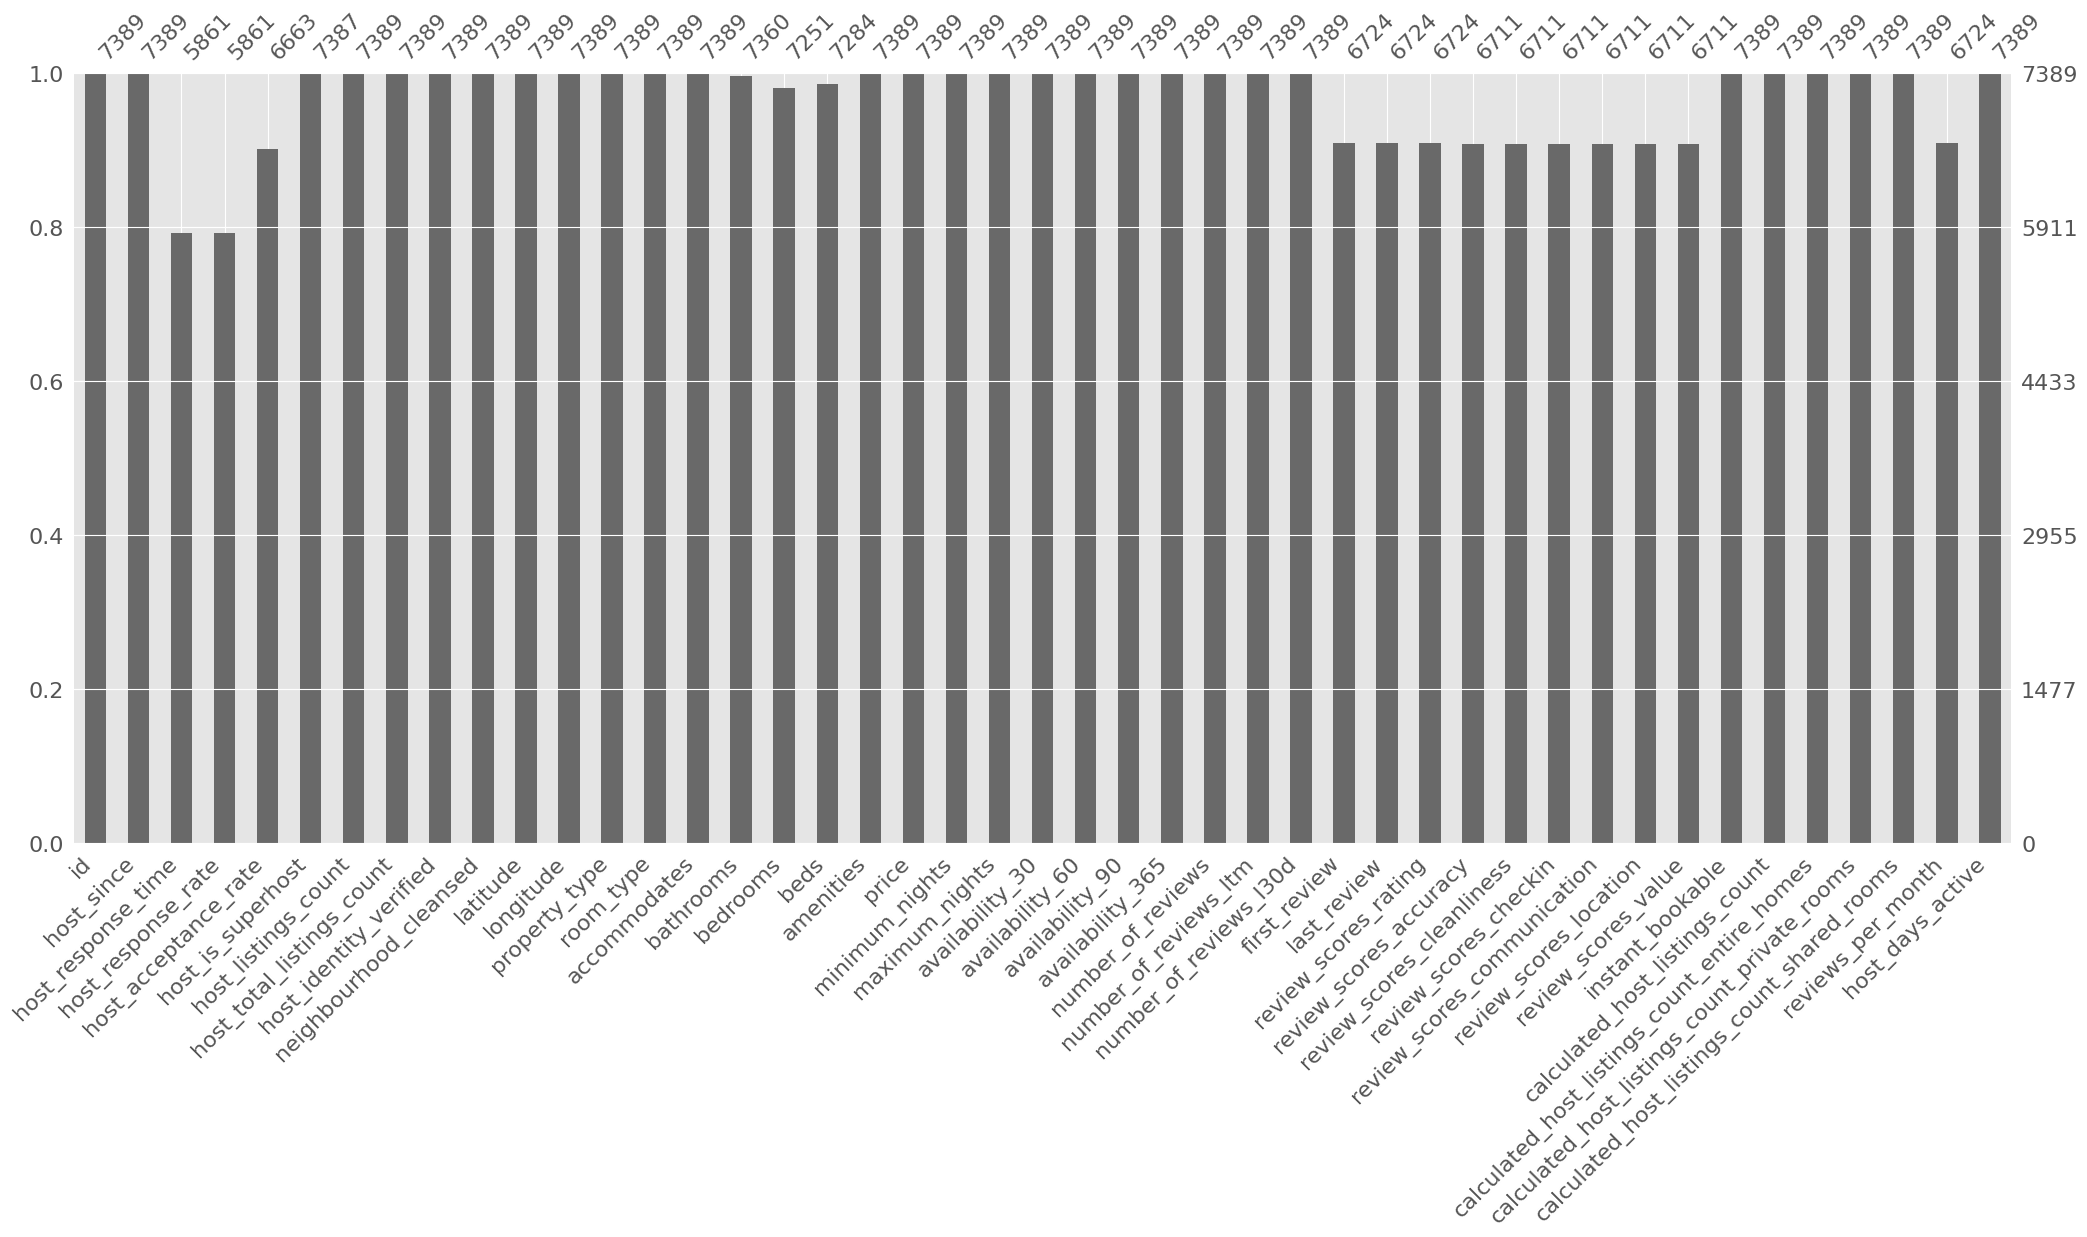

In [184]:
msno.bar(clean_listings)

In [185]:
property_types = pd.get_dummies(clean_listings.property_type)

In [186]:
property_types_copy = property_types.copy()
clean_property_types = pd.DataFrame(np.zeros(len(property_types.index)), index = property_types.index)


In [187]:
property_types_copy = property_types.copy()
clean_property_types = pd.DataFrame(np.zeros(len(property_types.index)), index = property_types.index, columns=["others"])
for i in ["entire", "private","shared", "room"]:
    for j in property_types_copy:
        if i.lower() in j.lower():
            try:
                if i in clean_property_types:
                    clean_property_types[i] += property_types[j]       
                    property_types.drop([j], axis = 1, inplace = True)      
                else:
                    clean_property_types[i] = property_types[j]
                    property_types.drop([j], axis = 1, inplace = True)
                     
            except KeyError:
                pass

clean_property_types["others"] = property_types.sum(axis=1)
clean_listings = pd.merge(clean_listings, clean_property_types, left_index=True, right_index=True)


In [188]:
# Removing , and $ form price, converting it to float
def remove_dollar(value):
    
    '''
    Requires string value
    Returns float without $ sign and comma sign.
    '''
    value = str(value)
    value = value.replace('$', '')
    value = value.replace(',', '')
    return float(value)

clean_listings['price'] = clean_listings['price'].apply(remove_dollar)

In [189]:
# Quartiles by the Empirical Rule

extprice = clean_listings['price'].quantile([0.0015, 0.9985])
display(extprice)
low = extprice[0.0015]
high = extprice[0.9985]


# Remove outliers in the dataframe to include only two standard deviations
clean_listings = clean_listings[clean_listings['price']>=low]
clean_listings = clean_listings[clean_listings['price']<=high]

0.0015      17.00
0.9985    3496.72
Name: price, dtype: float64

In [190]:
a = clean_listings['amenities'].apply(eval).tolist()
mlb = MultiLabelBinarizer()
onehot = mlb.fit_transform(a)

new_col_names = mlb.classes_

# Create new DataFrame with transformed/one-hot encoded IDs
ids = pd.DataFrame(onehot, columns=new_col_names,index=clean_listings['amenities'].index)

# Concat with original `Label` column
amen = pd.concat( [clean_listings[['amenities']], ids], axis=1 )
display(amen)

,amenities,Dove body soap,LG sound system,Neils Yard Remedies body soap,Various conditioner,'Simple' - sensitive skin experts shampoo,. conditioner,. shampoo,"100 Natural, cruelty free & eco friendly body soap","100"" HDTV with Apple TV, Disney+, Amazon Prime Video, Netflix","100"" HDTV with Chromecast, Apple TV","120"" HDTV with Netflix","13"" HDTV","14"" HDTV","15"" TV","16"" TV","17"" HDTV","18"" TV","18"" TV with standard cable","19"" HDTV","20"" TV","20"" TV with Amazon Prime Video, Fire TV, Netflix","22"" HDTV with Netflix, DVD player, standard cable","22"" TV with premium cable, Disney+, Amazon Prime Video, Netflix, standard cable, DVD player","22"" TV with standard cable","24"" HDTV with Amazon Prime Video, Disney+, Netflix",...,Wifi – 48 Mbps,Wifi – 49 Mbps,Wifi – 5 Mbps,Wifi – 6 Mbps,Wifi – 7 Mbps,Wifi – 8 Mbps,Wifi – 9 Mbps,Window AC unit,Window guards,Wine glasses,Wireless speakers Bluetooth sound system,Wirlpool stainless steel oven,With freezer compartment refrigerator,With icebox refrigerator,With small freezer compartment refrigerator,Wonderboom Bluetooth sound system,Yamaha Soundbar sound system,"Yamaha, Jongo sound system with Bluetooth and aux",You will have a bottle of versatile shower gel for yourself to use but you aslo can use any our shower products body soap,ZANUSSI stainless steel oven,Zanussi induction stove,Zanussi oven,Zanussi refrigerator,Zanussi stainless steel gas stove,Zanussi stainless steel oven,Zanussi stove
0,"[""Self check-in"", ""Hot water kettle"", ""Private...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"[""TV with standard cable"", ""Stove"", ""Self chec...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"[""Self check-in"", ""Stove"", ""Bed linens"", ""Chil...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"[""Free parking on premises \u2013 1 space"", ""S...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"[""Bathroom essentials"", ""Self check-in"", ""Carb...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7384,"[""Heating"", ""TV"", ""Free parking on premises"", ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7385,"[""TV with standard cable"", ""Stove"", ""Private e...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7386,"[""Self check-in"", ""Carbon monoxide alarm"", ""Lo...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7387,"[""TV with standard cable"", ""Stove"", ""Self chec...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [191]:
amen_copy = amen.copy()
clean_amen = pd.DataFrame(np.zeros(len(amen.index)), index = amen.index)
for i in [['TV'], ['soap', 'shampoo', 'conditioner'],['coffee'],['Clothing storage'], ['stove'], ['bathtub'],['heating'],['pets'],['smoke alarm'],['Smoking allowed'],['pool', 'sauna', 'hot tub'],['washer'],['dryer'],['refrigerator'],['Exercise equipment', 'gym'], ['oven'], ['sound'],['backyard'],['bbq', 'barbecue'],['wifi'], ['ac', 'air conditioner','air conditioning'], ['games', 'gaming','game'], ['view'], ['parking'], ['child', 'baby', 'high chair', 'crib']]:
    for j in amen_copy:
        if any([k.lower() in str(j).lower() for k in i]):
            try:
                if i[0] in clean_amen:
                    clean_amen[i[0]] += amen[j]       
                    amen.drop([j], axis = 1, inplace = True)      
                else:
                    clean_amen[i[0]] = amen[j]
                    amen.drop([j], axis = 1, inplace = True) 
            except KeyError:
                pass  
clean_listings = pd.merge(clean_listings, clean_amen, left_index=True, right_index=True)

In [192]:
for i in amen.columns:
    print(i)

amenities
Baking sheet
Bathroom essentials
Bed linens
Bedroom comforts
Bidet
Bikes
Blender
Boat slip
Books and reading material
Bread maker
Breakfast
Building staff
Carbon monoxide alarm
Ceiling fan
Changing table
Cleaning available during stay
Cleaning products
Cooking basics
Dining table
Dishes and silverware
EV charger
Elevator
Essentials
Ethernet connection
Extra pillows and blankets
Fire extinguisher
Fire pit
First aid kit
Free carport on premises
Free residential garage on premises
Freezer
Full kitchen
Hammock
Hangers
Host greets you
Hot water
Hot water kettle
Iron
Kayak
Keypad
Kitchen
Kitchenette
Laundromat nearby
Lock on bedroom door
Lockbox
Long term stays allowed
Luggage dropoff allowed
Microwave
Mini fridge
Mosquito net
Outdoor dining area
Outdoor furniture
Outdoor kitchen
Outdoor shower
Outlet covers
Patio or balcony
Piano
Ping pong table
Portable fans
Portable heater
Private entrance
Private living room
Private outdoor kitchen
Private patio or balcony
Record player
Rice ma

In [193]:
pd.set_option('display.max_columns', None)
clean_listings.head(3)

,id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_days_active,others,entire,private,shared,room,0,TV,soap,coffee,Clothing storage,stove,bathtub,heating,pets,smoke alarm,Smoking allowed,pool,washer,dryer,refrigerator,Exercise equipment,oven,sound,backyard,bbq,wifi,ac,games,view,parking,child
0,15420,2009-12-06,within a few hours,100.0,96.0,1.0,3,6,1,"Old Town, Princes Street and Leith Street",55.95759,-3.18805,Entire rental unit,Entire home/apt,2,1.0,1.0,1.0,"[""Self check-in"", ""Hot water kettle"", ""Private...",114.0,3,30,5,22,35,187,450,73,4,2011-01-18,2022-11-29,4.97,4.98,4.96,4.97,4.98,4.98,4.91,0,1,1,0,0,3.10,4851,0,1,0,0,0,0.0,1,3,1,1,0,1,1,0,1,0,0,2,2,1,0,1,1,0,0,1,3,0,2,1,3
1,707097,2012-07-29,within a day,50.0,84.0,0.0,9,16,1,"Old Town, Princes Street and Leith Street",55.94980,-3.18354,Entire condo,Entire home/apt,9,2.0,3.0,7.0,"[""TV with standard cable"", ""Stove"", ""Self chec...",598.0,2,1000,0,4,4,210,67,7,0,2013-01-03,2022-09-22,4.38,4.32,4.40,4.69,4.72,4.94,4.09,1,8,6,2,0,0.55,3885,0,1,0,0,0,0.0,1,1,0,0,1,0,1,0,1,0,0,1,2,1,0,1,0,1,0,1,3,0,0,1,1
2,728199,2012-10-06,within an hour,100.0,95.0,1.0,1,2,1,Polwarth,55.93692,-3.22414,Private room in rental unit,Private room,3,1.0,1.0,1.0,"[""Self check-in"", ""Stove"", ""Bed linens"", ""Chil...",60.0,1,14,6,24,49,195,354,52,2,2012-10-22,2022-12-04,4.82,4.86,4.81,4.95,4.97,4.73,4.79,0,1,0,1,0,2.86,3816,0,0,1,0,0,0.0,1,3,0,1,1,0,1,0,1,0,0,2,2,1,0,1,0,1,0,1,3,0,0,1,4


In [194]:
clean_listings.drop(['availability_30', 'availability_60', 'availability_365'], axis = 1, inplace = True)

<AxesSubplot:>

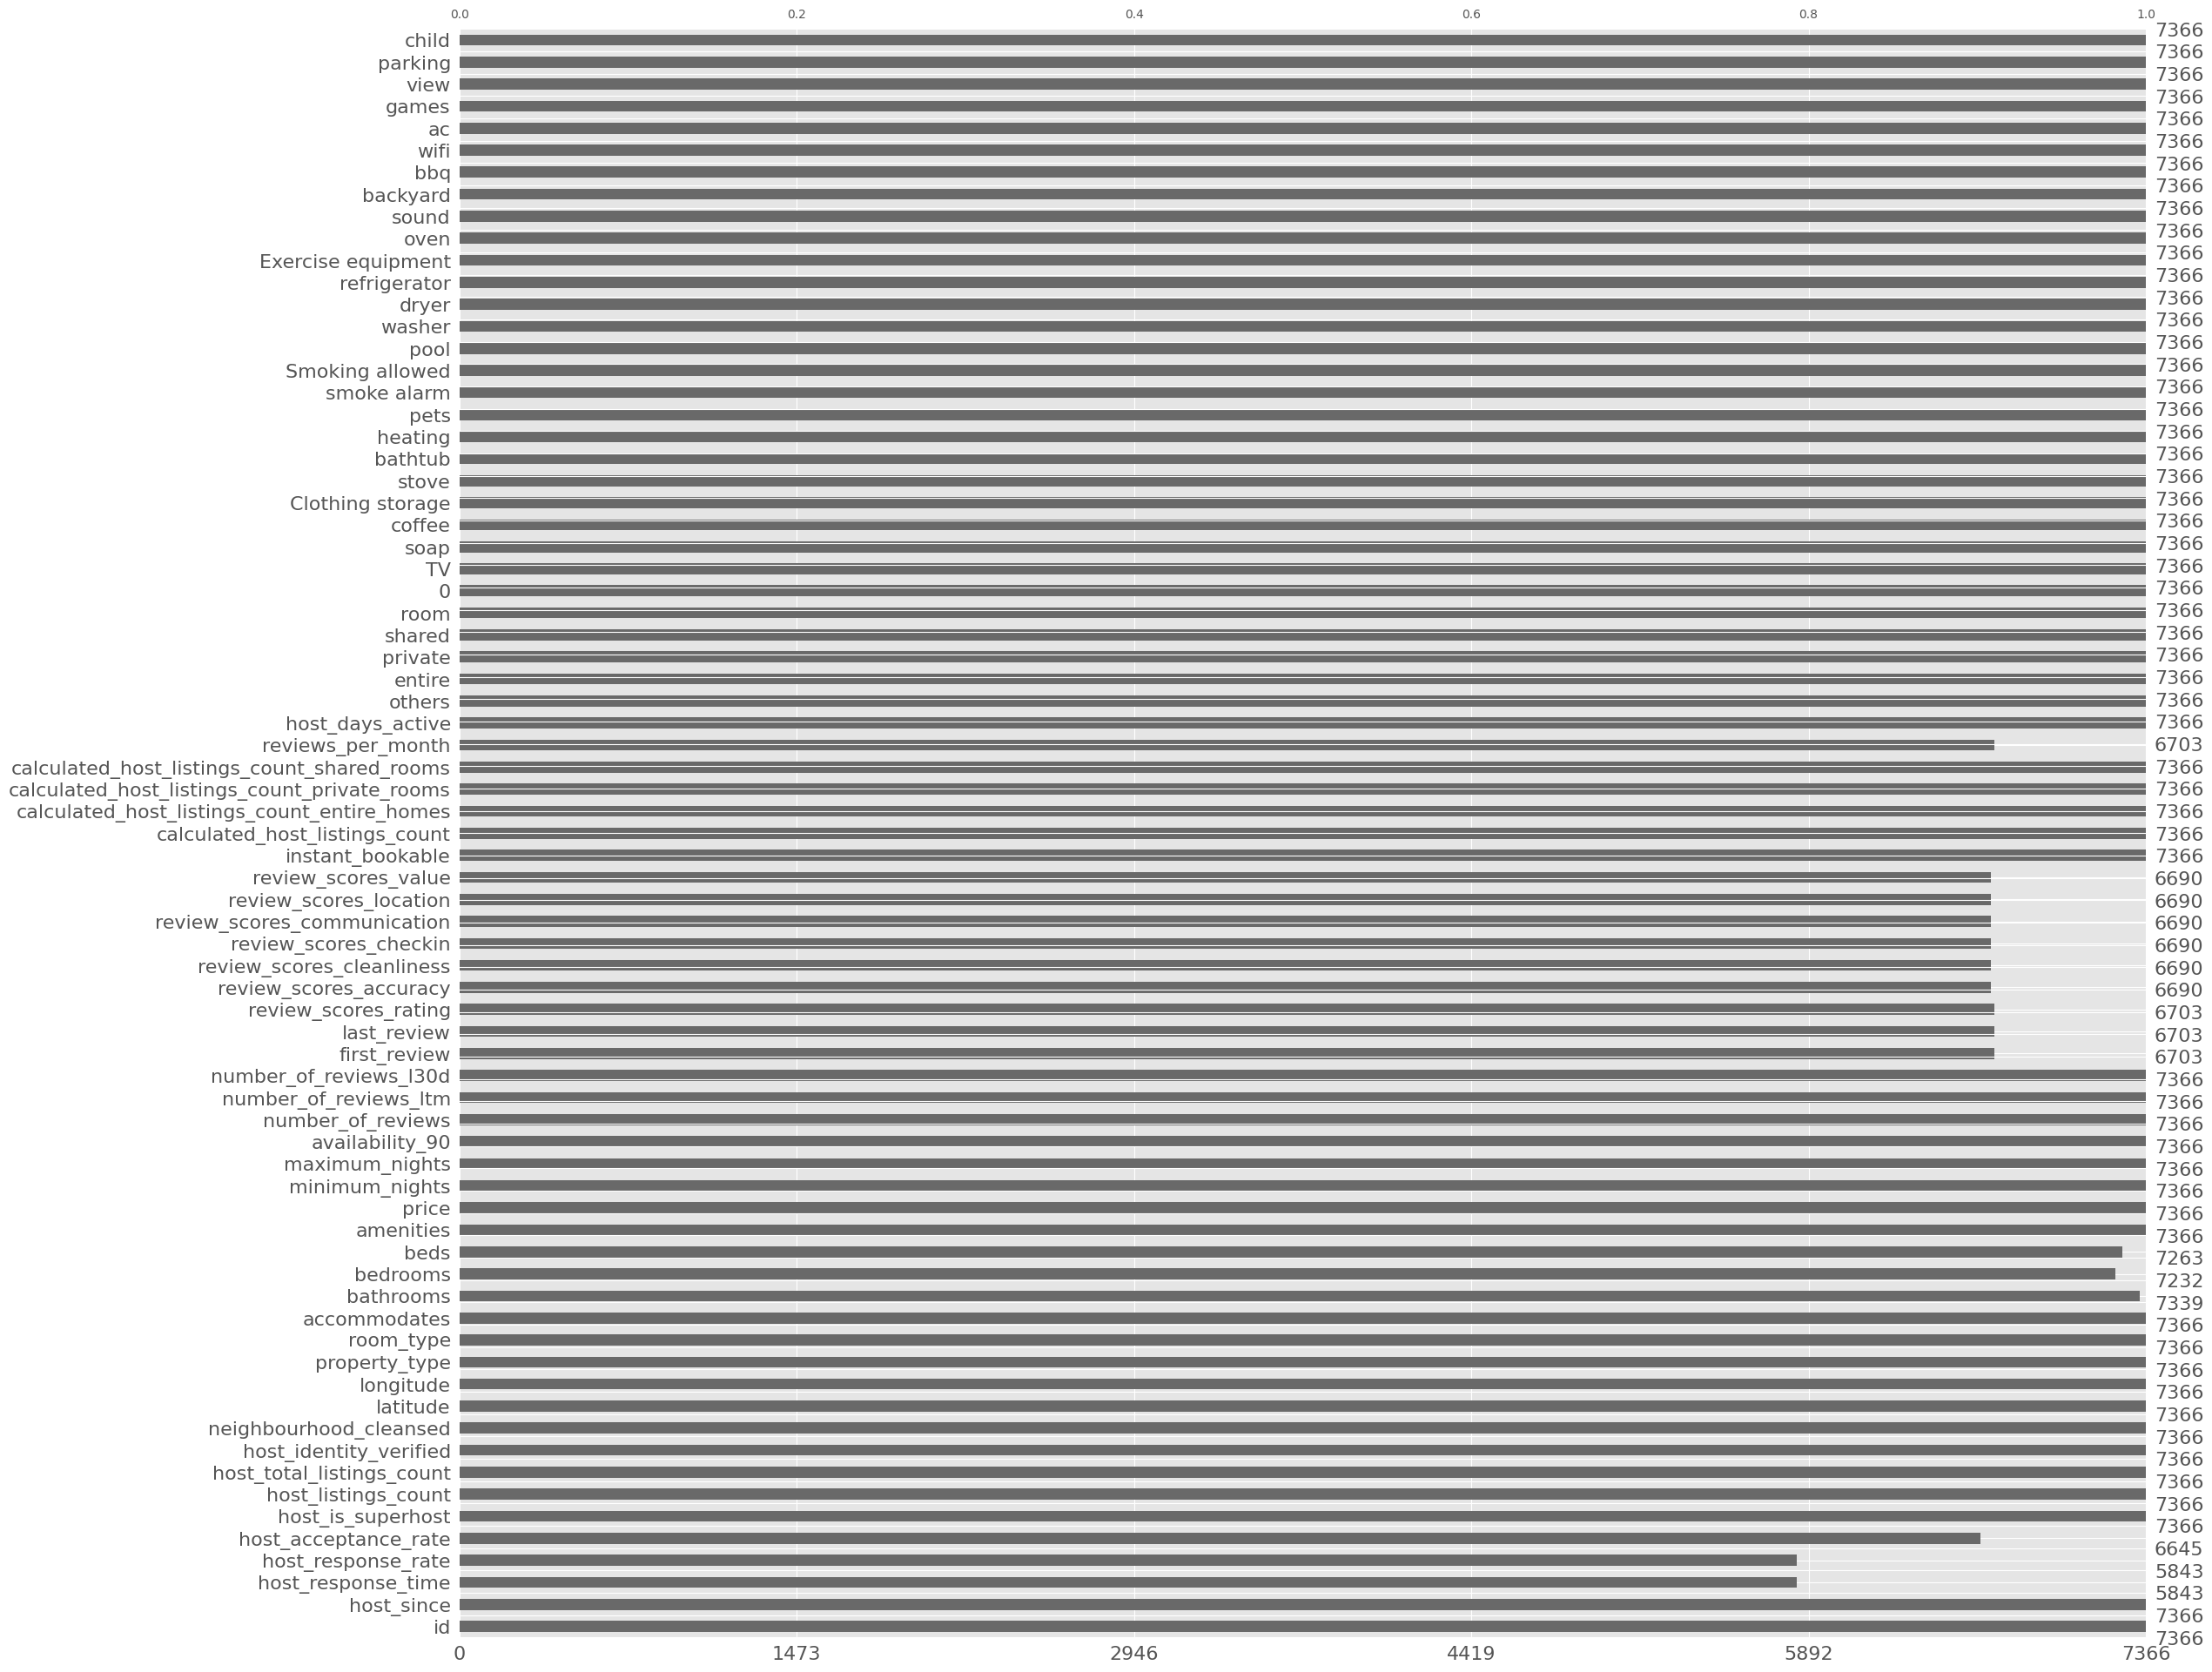

In [195]:
msno.bar(clean_listings)

## MAP BY NEIGHBOURHOOD

In [147]:
# Creating a dataframe of listing counts and median price by borough
map_df = pd.DataFrame(clean_listings.groupby('neighbourhood_cleansed').size())
map_df.rename(columns={0: 'number_of_listings'}, inplace=True)
map_df['median_price'] = clean_listings.groupby('neighbourhood_cleansed').price.median().values

# Joining the dataframes
comb_map_df = neighbourhoods.set_index('neighbourhood').join(map_df)

comb_map_df.head()

,neighbourhood_group,geometry,number_of_listings,median_price
neighbourhood,,,,
Balerno and Bonnington Village,NaN,"MULTIPOLYGON (((-3.35805 55.91088, -3.35950 55...",14,111.0
Currie West,NaN,"MULTIPOLYGON (((-3.30557 55.92039, -3.30418 55...",9,65.0
Currie East,NaN,"MULTIPOLYGON (((-3.30808 55.89430, -3.30870 55...",7,71.0
Baberton and Juniper Green,NaN,"MULTIPOLYGON (((-3.28635 55.91564, -3.28617 55...",8,72.5
Bonaly and The Pentlands,NaN,"MULTIPOLYGON (((-3.30808 55.89430, -3.30834 55...",18,78.0


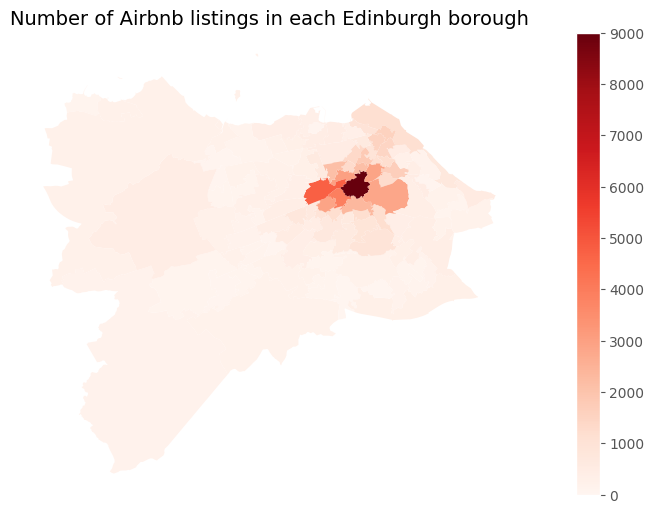

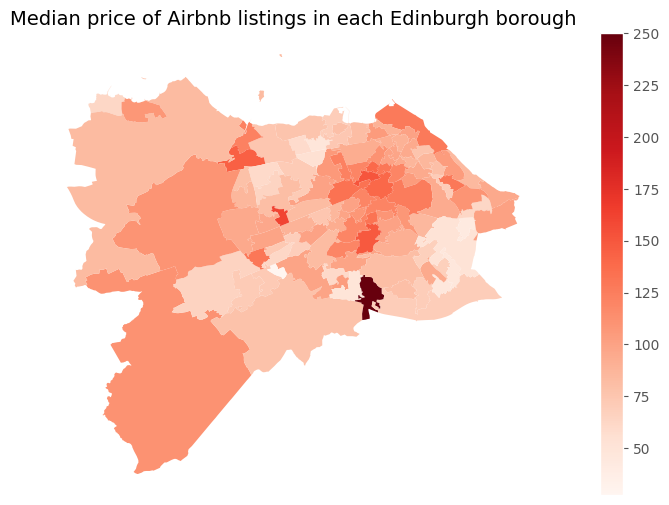

In [148]:
# Plotting the number of listings in each borough
fig1, ax1 = plt.subplots(1, figsize=(15, 6))
comb_map_df.plot(column='number_of_listings', cmap='Reds', ax=ax1)
ax1.axis('off')
ax1.set_title('Number of Airbnb listings in each Edinburgh borough', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=0, vmax=9000))
sm._A = [] # Creates an empty array for the data range
cbar = fig1.colorbar(sm)
plt.show()

# Plotting the median price of listings in each borough
fig2, ax2 = plt.subplots(1, figsize=(15, 6))
comb_map_df.plot(column='median_price', cmap='Reds', ax=ax2)
ax2.axis('off')
ax2.set_title('Median price of Airbnb listings in each Edinburgh borough', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=min(comb_map_df.median_price), vmax=max(comb_map_df.median_price)))
sm._A = [] # Creates an empty array for the data range
cbar = fig2.colorbar(sm)
plt.show()

## DATA INSIGHTS

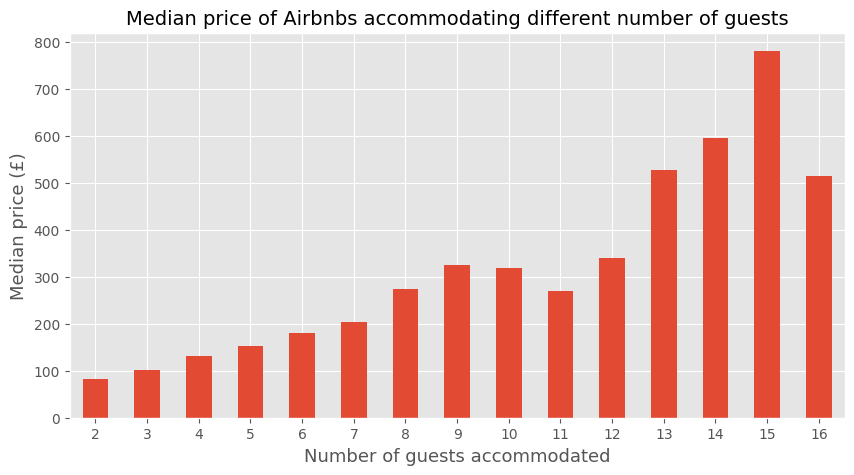

In [149]:
# Seaborn graph to be implemented

plt.figure(figsize=(10,5))
clean_listings.groupby('accommodates').price.median().plot(kind='bar')
plt.title('Median price of Airbnbs accommodating different number of guests', fontsize=14)
plt.xlabel('Number of guests accommodated', fontsize=13)
plt.ylabel('Median price (£)', fontsize=13)
plt.xticks(rotation=0)
plt.xlim(left=0.5)
plt.show()

array([[<AxesSubplot:title={'center':'accommodates'}>,
        <AxesSubplot:title={'center':'bathrooms'}>],
       [<AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'beds'}>]], dtype=object)

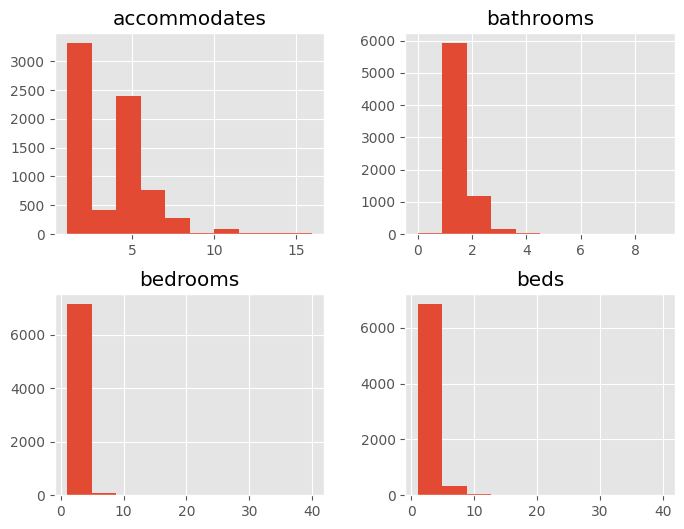

In [150]:
clean_listings[['accommodates', 'bathrooms', 'bedrooms', 'beds']].hist(figsize=(8,6))

## RUNNING ML MODEL

In [151]:
clean_listings.drop([0,'calculated_host_listings_count_shared_rooms','calculated_host_listings_count_private_rooms','calculated_host_listings_count_entire_homes','calculated_host_listings_count','id', 'longitude','latitude','host_since','first_review', 'last_review', 'amenities', 'property_type', 'neighbourhood_cleansed'], axis = 1, inplace = True)

In [153]:
clean_listings.host_response_time.replace({'within an hour':10,'within a few hours': 7, 'within a day': 4, 'a few days or more': 1, 'unknown':5}, inplace=True)

<AxesSubplot:>

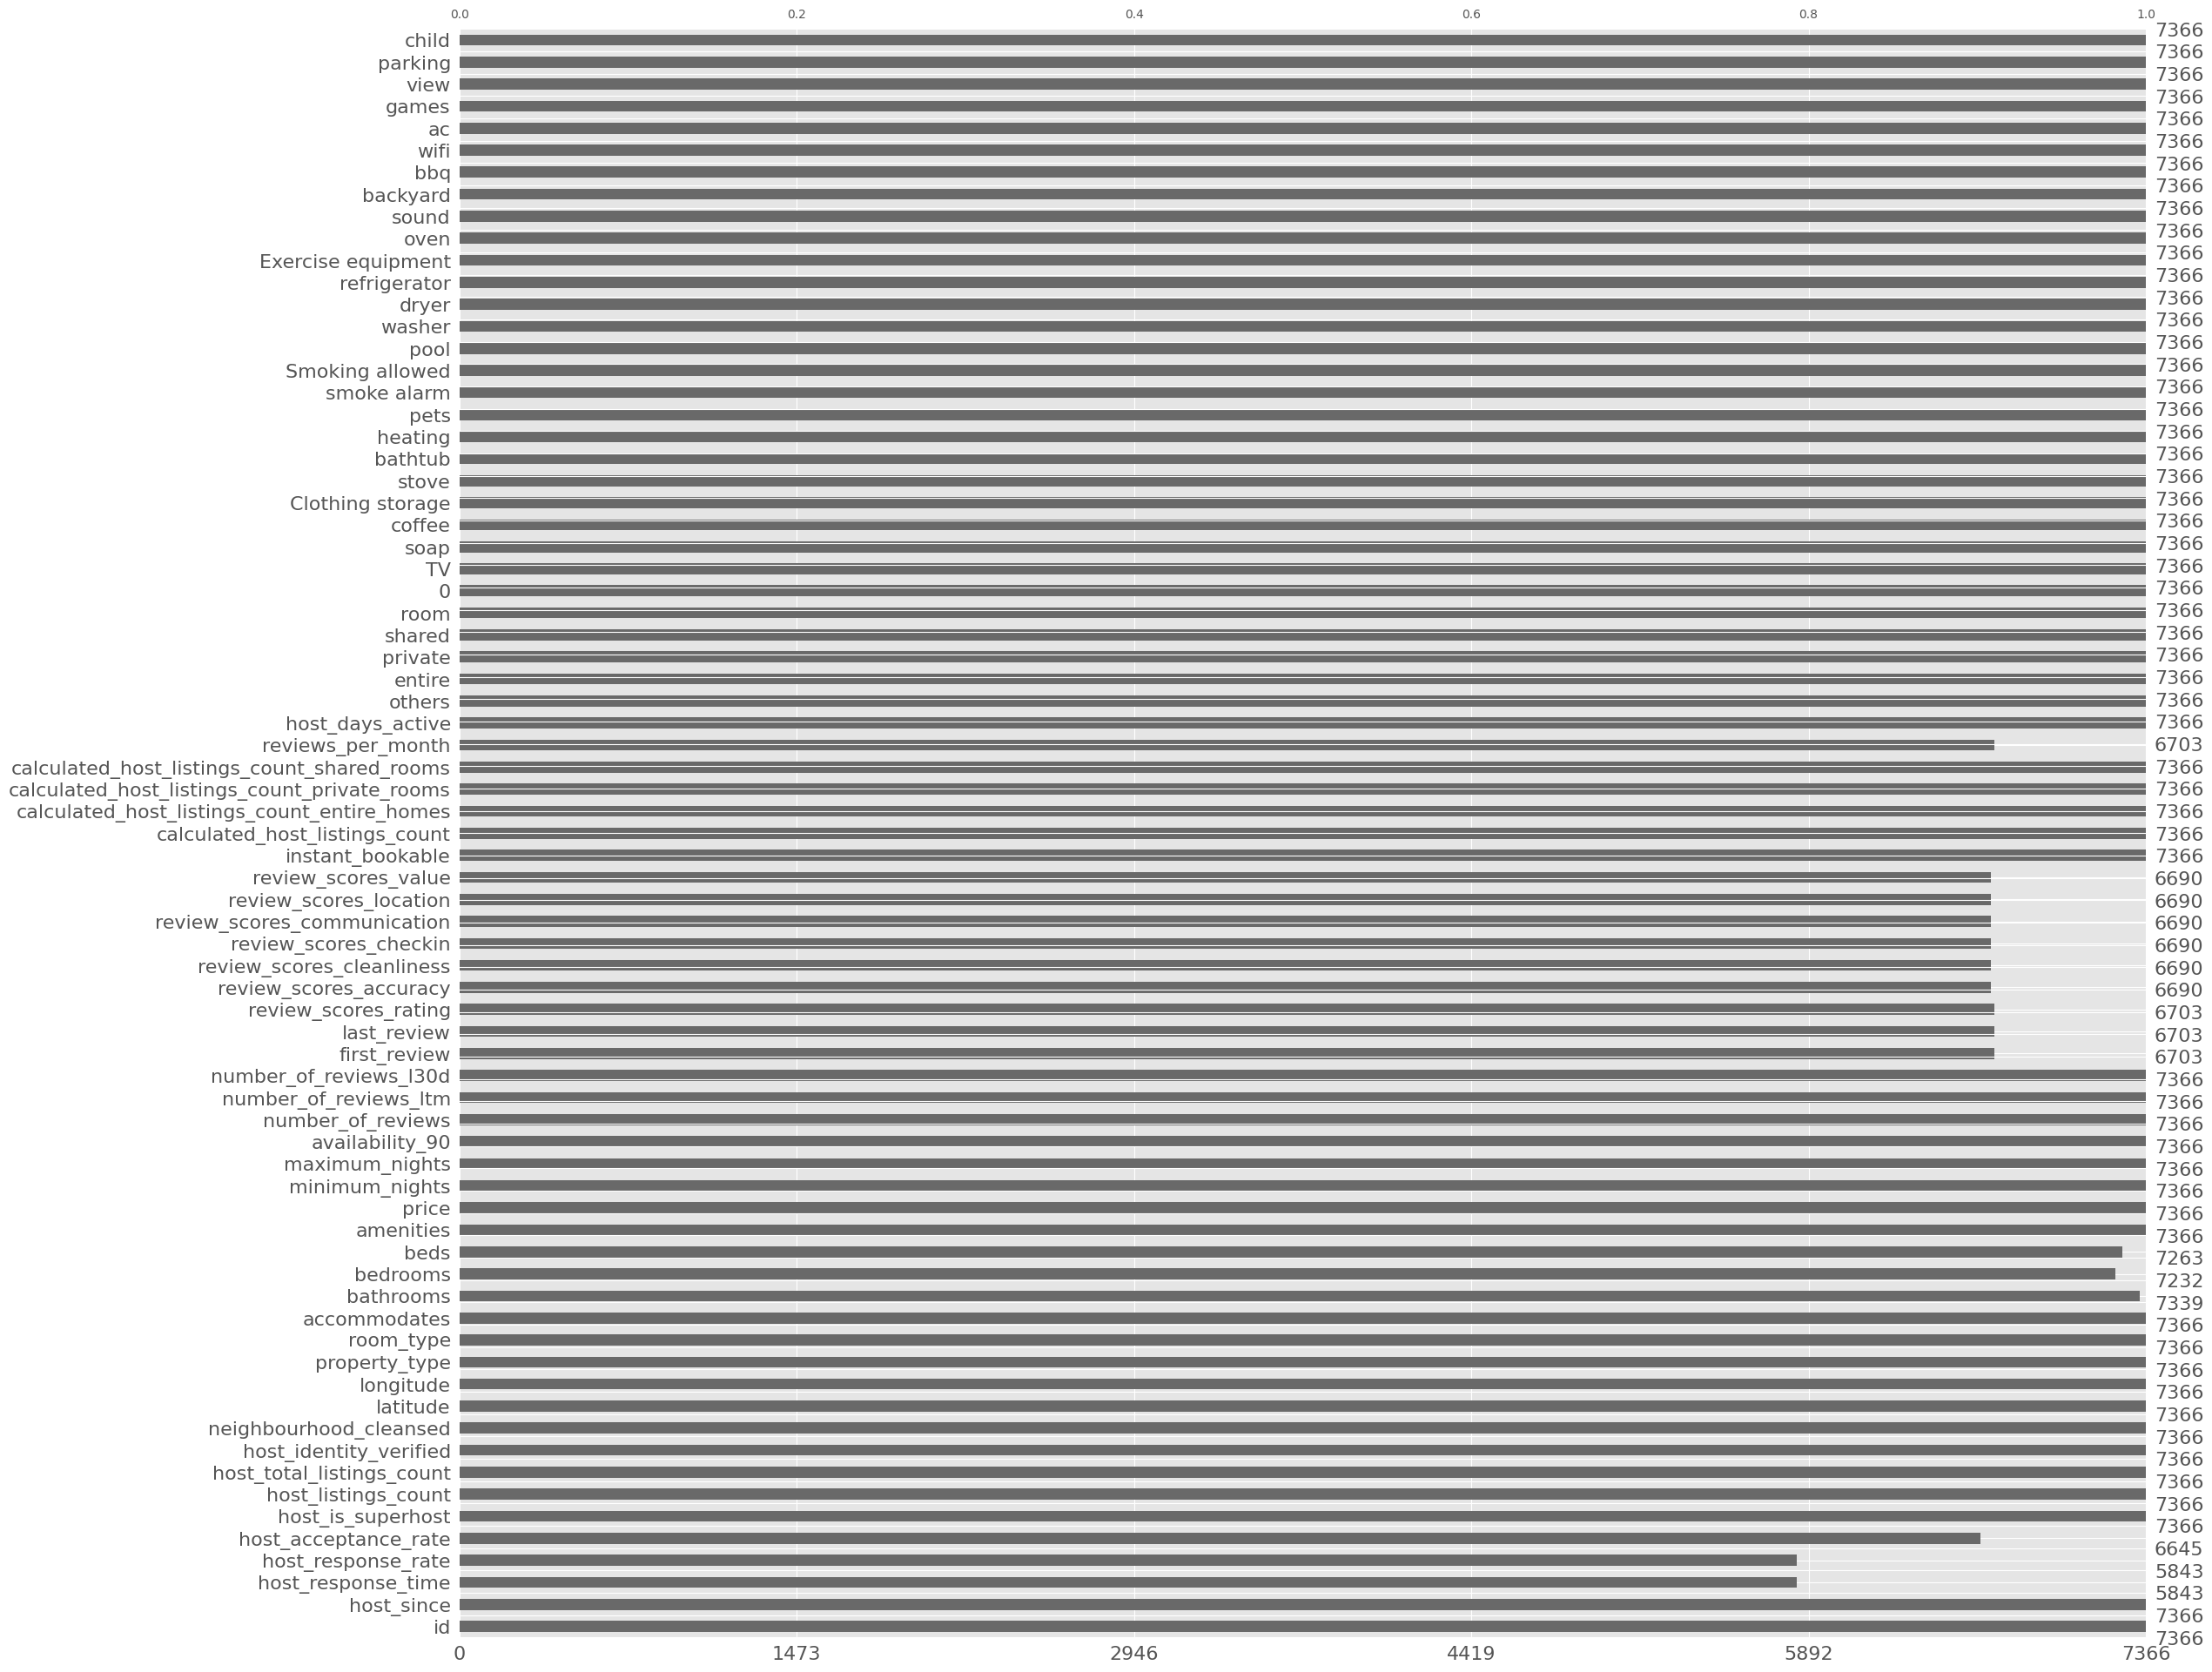

In [196]:
msno.bar(clean_listings)

In [197]:
clean_listings.host_response_time.value_counts()
# ordinaly response time, response rate, drop calculated stuff


within an hour        4589
within a few hours     658
within a day           481
a few days or more     115
Name: host_response_time, dtype: int64

In [155]:
model_df = pd.get_dummies(clean_listings)
model_df.dropna(inplace = True)
print(model_df.shape)
display(model_df.head(3))


(5242, 62)


,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,availability_90,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,host_days_active,others,entire,private,shared,room,TV,soap,coffee,Clothing storage,stove,bathtub,heating,pets,smoke alarm,Smoking allowed,pool,washer,dryer,refrigerator,Exercise equipment,oven,sound,backyard,bbq,wifi,ac,games,view,parking,child,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,7.0,100.0,96.0,1.0,3,6,1,2,1.0,1.0,1.0,114.0,3,30,35,450,73,4,4.97,4.98,4.96,4.97,4.98,4.98,4.91,0,3.10,4851,0,1,0,0,0,1,3,1,1,0,1,1,0,1,0,0,2,2,1,0,1,1,0,0,1,3,0,2,1,3,1,0,0,0
1,4.0,50.0,84.0,0.0,9,16,1,9,2.0,3.0,7.0,598.0,2,1000,4,67,7,0,4.38,4.32,4.40,4.69,4.72,4.94,4.09,1,0.55,3885,0,1,0,0,0,1,1,0,0,1,0,1,0,1,0,0,1,2,1,0,1,0,1,0,1,3,0,0,1,1,1,0,0,0
2,10.0,100.0,95.0,1.0,1,2,1,3,1.0,1.0,1.0,60.0,1,14,49,354,52,2,4.82,4.86,4.81,4.95,4.97,4.73,4.79,0,2.86,3816,0,0,1,0,0,1,3,0,1,1,0,1,0,1,0,0,2,2,1,0,1,0,1,0,1,3,0,0,1,4,0,0,1,0


In [156]:

y = model_df['price']
X = model_df.drop(['price'], axis=1) 
#X.fillna(0, inplace=True)

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

In [159]:
X.columns.tolist()

['host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_listings_count',
 'host_total_listings_count',
 'host_identity_verified',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'minimum_nights',
 'maximum_nights',
 'availability_90',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'number_of_reviews_l30d',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'instant_bookable',
 'reviews_per_month',
 'host_days_active',
 'others',
 'entire',
 'private',
 'shared',
 'room',
 'TV',
 'soap',
 'coffee',
 'Clothing storage',
 'stove',
 'bathtub',
 'heating',
 'pets',
 'smoke alarm',
 'Smoking allowed',
 'pool',
 'washer',
 'dryer',
 'refrigerator',
 'Exercise equipment',
 'oven',
 'sound',
 'backyard',
 'bbq',
 'wifi',
 'ac',
 'games',
 'view',
 'parking',
 'child',
 'room_type_Entire home/apt',
 'room_

In [ ]:
regr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.31, max_depth=9, subsample=1.0,
                                 random_state=42)
regr.fit(X_train, y_train)
print(r2_score(y_val, regr.predict(X_val)))

0.4908920636148182


In [160]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 123)
# Train the model on training data
rf.fit(X_train, y_train);

In [161]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_val)
# Calculate the absolute errors
errors = abs(predictions - y_val)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 40.65 degrees.


In [162]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_val)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 65.23 %.


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [199]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=123)

# instantiate the XGBoost regressor with default hyperparameters
xgb_model = XGBRegressor()

# train the model on the training data
xgb_model.fit(X_train, y_train)

# make predictions on the testing data
y_pred = xgb_model.predict(X_test)

print(r2_score(y_test, y_pred))
# evaluate the model performance using mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean squared error: %.2f" % mse)

0.23630311889653444
Mean squared error: 16609.72


In [163]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(model_df.columns.tolist(), importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: bedrooms             Importance: 0.2
Variable: bathrooms            Importance: 0.1
Variable: instant_bookable     Importance: 0.06
Variable: accommodates         Importance: 0.05
Variable: number_of_reviews    Importance: 0.04
Variable: review_scores_communication Importance: 0.04
Variable: host_listings_count  Importance: 0.03
Variable: maximum_nights       Importance: 0.03
Variable: availability_90      Importance: 0.03
Variable: reviews_per_month    Importance: 0.03
Variable: host_total_listings_count Importance: 0.02
Variable: price                Importance: 0.02
Variable: number_of_reviews_l30d Importance: 0.02
Variable: review_scores_rating Importance: 0.02
Variable: review_scores_accuracy Importance: 0.02
Variable: review_scores_checkin Importance: 0.02
Variable: review_scores_location Importance: 0.02
Variable: room                 Importance: 0.02
Variable: TV                   Importance: 0.02
Variable: dryer                Importance: 0.02
Variable: wifi         